The easiest way of PCA. Only a mask and a data series.

(176, 540, 654)


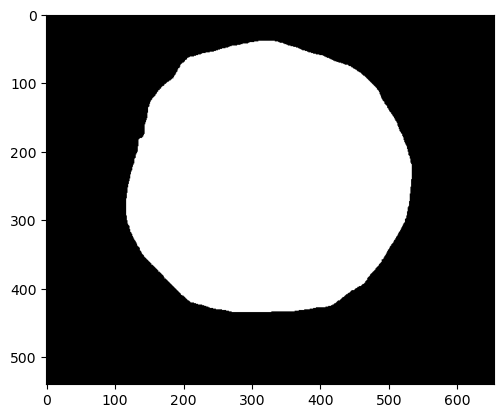

In [40]:
import Common_Functions as cf
from OI_Functions.Map_Subtractor import Sub_Map_Generator
from OI_Functions.VDaQ_dRR_Generator import BLK2DRR
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import cv2
import pandas as pd


wp = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\Run01_G8\Processed'
drr_frame = cf.Load_Variable(cf.join(wp,'dRR_Dictionaries.pkl'))[5].reshape(-1,540,654)
mask_path = r'D:\ZR\_Data_Temp\VDaQ_Data\200910_L80_LM_OI\_V2_Sripe_Method\Masks'
chambermask = cv2.imread(cf.join(mask_path,'chambermask.bmp'),0)>128

print(drr_frame.shape)
plt.imshow(chambermask,cmap='gray')

Use mask to get useful pix for PCA.

In [41]:
from sklearn.decomposition import PCA
# generate N_sample*N_features frame
spon_data_1d = drr_frame[:,chambermask]
print(spon_data_1d.shape)

# then set up pca, reserve 50 comps
pca = PCA(n_components=20)
pca.fit(spon_data_1d)
print(f'Explained VAR Ratio: {pca.explained_variance_ratio_[:20].sum()}')

(176, 130712)
Explained VAR Ratio: 0.967674155056232


After PCA, we will recover graph to 2D shape.

In [42]:
pca.components_.shape

(20, 130712)

<AxesSubplot: >

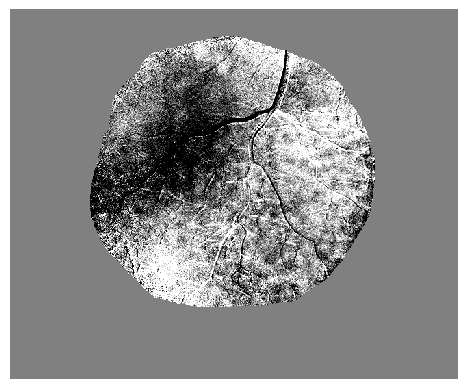

In [58]:
recovered_pc = np.zeros(shape = (540,654))
recovered_pc[chambermask == 1] = pca.components_[5,:]
lim = 0.003
sns.heatmap(recovered_pc,center = 0,xticklabels=False,yticklabels=False,square=True,cmap='gray',cbar = False,vmax = lim,vmin = -lim)

---
As we can see above, we will need space filter to get proper pca. The space blob sucks.

In [135]:
from scipy.ndimage import gaussian_filter
clip_std = 2.5
HP_sigma = 20
LP_sigma = 0.75

filted_drr = np.zeros(shape = (176,540,654))
for i in tqdm(range(176)):
    c_graph = drr_frame[i,:,:]
    c_clipped = np.clip(c_graph,c_graph.mean()-clip_std*c_graph.std(),c_graph.mean()+clip_std*c_graph.std())
    HP_graph = gaussian_filter(input = c_clipped, sigma = HP_sigma)
    LP_graph = gaussian_filter(input = c_clipped, sigma = LP_sigma)
    processed_graph = (LP_graph-HP_graph)
    filted_drr[i,:,:] = processed_graph


  1%|          | 2/176 [00:00<00:19,  9.08it/s]

100%|██████████| 176/176 [00:17<00:00, 10.23it/s]


In [136]:
filted_spon_data_1d = filted_drr[:,chambermask]
# filted_spon_data_1d = drr_frame[:,chambermask]
print(filted_spon_data_1d.shape)

# then set up pca, reserve 20 comps
pca2 = PCA(n_components=20)
pca2.fit(filted_spon_data_1d)
print(f'Explained VAR Ratio: {pca2.explained_variance_ratio_[:20].sum()}')

(176, 130712)
Explained VAR Ratio: 0.9254606202843347


<AxesSubplot: >

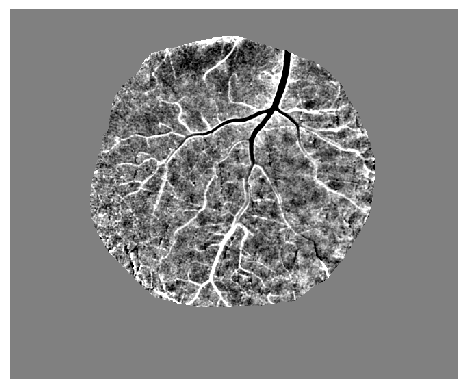

In [148]:
recovered_pc = np.zeros(shape = (540,654))
recovered_pc[chambermask == 1] = pca2.components_[3,:]
lim = 0.005
sns.heatmap(recovered_pc,center = 0,xticklabels=False,yticklabels=False,cmap='gist_gray',square=True,cbar = False,vmax = lim,vmin = -lim)